In [1]:
"""
Cellular voltage rhythmicity organizes distinct spiking output modes in the hippocampus (2022)
Eric Lowet, Rebecca A. Mount, Ulises Chialva, Rodrigo De Oliveira Pena, Sheng Xiao, Samuel L. Zhou, 
Daniel J. Sheehan, Hua-an Tseng, Howard Gritton, Sanaya Shroff, Krishnakanth Kondabolu, Cyrus Cheung, 
Jerome Mertz, Michael E. Hasselmo, Horacio Rotstein, Xue Han  

Biophysical bursting model with HCN. 
"""

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
import pandas as pd
import time
from scipy import signal
from scipy import stats
from scipy.ndimage import gaussian_filter
import seaborn as sns
import random
import pylab
pylab.rcParams['savefig.dpi'] = 120
#matplotlib inline

# these lines for Google Colab mount drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# images_dir = '/content/gdrive/MyDrive/images'

In [2]:
"""stim functions"""

Ipoisson = lambda r: 1*(np.random.rand()<r*10**-3*dt)
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)


In [3]:
#@title HHca2
class HHca2:
    """Golomb model with Ca + second compartment with I_h"""
    nid=0 #default neuron id
    sendspk=0
    
    C = 1
    Gl=0.05
    Vl = -70
    Gna = 35
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30
    deltam = 9.5
    Vna = 55
    Gkdr = 6
    thetah = -45
    deltah = -7
    thetaht= -40.5
    deltaht= -6
    Vk = -90
    thetap = -47 #varies between -47mV and -41mV
    deltap = 3
    thetan = -35
    deltan = 10
    thetant =-27
    deltant=-15
    Ga = 1.4
    thetaa = -50
    deltaa = 20
    taub = 15
    thetab = -80
    deltab = -6
    Gm = 1
    tauz = 75
    thetaz = -39
    deltaz = 5
    
    Gca = 0. #varies between 0 and 0.2 mS/cm2
    Gc = 10
    Gsahp = 5
    Vca = 120
    thetar=-20
    deltar=10
    taur=1
    thetac=-30
    deltac=7
    tauc=2
    ac=6
    tauq=450
    aq=2
    
    nu=0.13
    tauca=13
    
    Iapp = 0.9
    Inoise=0.0

    """second compartment parameters"""
    Gl2 = Gl
    Gh2 = 2.
    Vh2 = -32.9
    Iapp2 = 0.9

    """couplings between compartments"""
    Gsd = 0.2
    Gds = 0.2
    
    D = 0.0   
    Dz = .5e-5
    
    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=5*0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth= 0#-20
    Iin = 0
    Iin2 = 0

    countdelay=0
    countdelay2=0
    
    spktimes = []

    gext = 8 #ext
    tauext=10 #ext

    gextdend = 8 #ext
    tauextdend=10 #ext

    
    def __init__(self,nid=1,D=0.1,Gnap=0.3,Ca_acum=0.0001, No = 1.0, Ni=1.0, Dz=.5e-5):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  1.0/(1+np.exp(-(V-self.thetah)/self.deltah))
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  1.0/(1+np.exp(-(V-self.thetan)/self.deltan))
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  1.0/(1+np.exp(-(V-self.thetap)/self.deltap))
        self.ainf= lambda V:  1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa))
        self.binf= lambda V:  1.0/(1+np.exp(-(V-self.thetab)/self.deltab))
        self.zinf= lambda V:  1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz))
        
        self.rinf= lambda V:  1.0/(1+np.exp(-(V-self.thetar)/self.deltar))
        self.cinf= lambda V:  1.0/(1+np.exp(-(V-self.thetac)/self.deltac))
        self.dinf= lambda Ca_acum:  1.0/(1+self.ac/Ca_acum)
        self.qinf= lambda Ca_acum:  1.0/(1+(self.aq**4)/(Ca_acum**4))

        """for h-current of dendrite"""
        self.h2_inf = lambda V: 1./(1. + np.exp((V + 84.)/10.2))
        self.tauh2 = lambda V: 1./(np.exp(-17.9 - 0.116*V ) + np.exp(-1.84 + 0.09*V )) + 0.1

        self.Nv = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        self.Nv2 = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        
        self.nid = nid
        self.Dz = Dz
        self.D = D      
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0       
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Ca_acum= Ca_acum #
        self.Gnap= Gnap
        self.q=0

        self.sext = 0 #external current
        self.sextdend = 0
        
        """second compartment variables"""
        self.v2 = -72.
        self.h2 = 0
        self.s2 = 0
        
        self.spktimes = []
        
    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,v2,h2,s2,sext,sextdend, stim, stim2):
        Isyn = self.Gie*self.sie*(v-self.Ein)
        self.Iin = Isyn

        Isyn2 = self.Gie*self.soe*(v2-self.Ein)
        self.Iin2 = Isyn2

        Iext = self.gext*sext * (v-self.Ein) #added to the soma
        Iextdend = self.gextdend*sextdend * (v-self.Ein) #added to the dendrite
        """Ext inputs"""
        ksext = -sext/self.tauext
        ksextdend = -sextdend/self.tauextdend
        
        """somatic currents"""
        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk) 
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)
        
        Ica  = self.Gca * (r**2) * (v-self.Vca) 
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)

        """conection between v and v2"""
        Isd = self.Gsd*(v2-v)
        Ids = self.Gds*(v-v2)

        """h-current term for v2"""
        Il2 = self.Gl2 * (v2- self.Vl)
        Ih2 = self.Gh2 * h2 * (v2- self.Vh2)
        
        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp - Isyn + Isd  + stim - Iext
        Itotal2 = self.Iapp2 - Il2 - Ih2 - Isyn2 + Ids + stim2 - Iextdend

        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz     
        
        kr = (self.rinf(v)-r)/self.taur  
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq
        
        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa
        ks2 = self.Nv2(v2)*(1-s2)/self.tauR_ampa - s2/self.tauD_ampa

        """v2 compartment"""
        kv2 = Itotal2 / (self.C)
        kh2 = (self.h2_inf(v2)-h2)/self.tauh2(v2)

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks, kv2, kh2, ks2, ksext, ksextdend

    def _Updatev(self,stim,stim2,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
  
        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s, k1v2, k1h2, k1s2, k1sext, k1sextdend = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,self.v2,self.h2,self.s2,self.sext,self.sextdend,stim,stim2)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2
        a_v2 = self.v2 + k1v2*dt/2
        a_h2 = self.h2 + k1h2*dt/2
        a_s2 = self.s2 + k1s2*dt/2
        a_sext= self.sext + k1sext*dt/2
        a_sextdend= self.sextdend + k1sextdend*dt/2

        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s, k2v2, k2h2, k2s2, k2sext, k2sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2
        a_v2 = self.v2 + k2v2*dt/2
        a_h2 = self.h2 + k2h2*dt/2
        a_s2 = self.s2 + k2s2*dt/2
        a_sext= self.sext + k2sext*dt/2
        a_sextdend= self.sextdend + k2sextdend*dt/2

        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s, k3v2, k3h2, k3s2, k3sext, k3sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt
        a_v2 = self.v2 + k3v2*dt
        a_h2 = self.h2 + k3h2*dt
        a_s2 = self.s2 + k3s2*dt
        a_sext= self.sext + k3sext*dt
        a_sextdend= self.sextdend + k3sextdend*dt

        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s, k4v2, k4h2, k4s2, k4sext, k4sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        self.Inoise = np.random.randn()*np.sqrt(2*self.D*dt)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + self.Inoise
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6 + np.random.randn()*np.sqrt(2*self.Dz*dt)
        if self.z<0:
         self.z = 0
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6
        self.v2 += dt*(k1v2+2*k2v2+2*k3v2+k4v2)/6
        self.h2 += dt*(k1h2+2*k2h2+2*k3h2+k4h2)/6
        self.s2 += dt*(k1s2+2*k2s2+2*k3s2+k4s2)/6
        self.sext += dt*(k1sext+2*k2sext+2*k3sext+k4sext)/6
        self.sextdend += dt*(k1sextdend+2*k2sextdend+2*k3sextdend+k4sextdend)/6

        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1
        
    def add_external(self):
       self.sext += 1

    def add_externaldend(self):
       self.sextdend += 1
        
    def eval(self,stim,stim2,sie,soe,dt,time):
        self._Updatev(stim,stim2,sie,soe,dt,time)

execution time 111.99211096763611


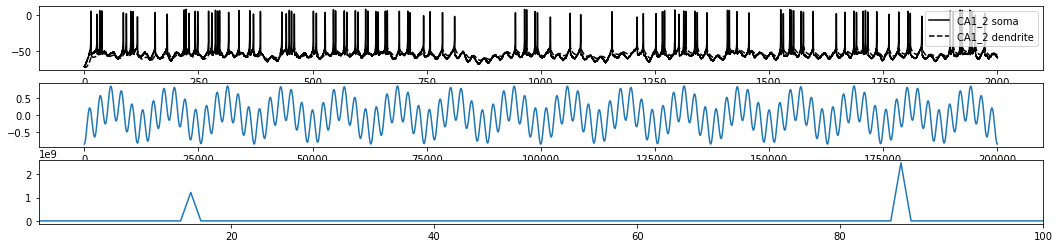

In [5]:
#@title Cell simulation
#%%script false


#### testing input
tf = 2000
dt = 0.01
N = round(tf/dt)
D=0.1
Dz=2*1.0e-5 
Dz=1.0e-5 
Ne=1

Input = []
Amp=0.5
for i in range(N):
    Itheta = Izap(i,8,Amp)
    Igamma = Izap(i,43,1*Amp)
    Input.append(0.7*Itheta + Igamma)


neuron_list = HHca2(D=D, Gnap = 0.0, Dz=Dz)

v4 = np.empty(N)
v4d = np.empty(N)

start = time.time()
Isoma = []
Idend = []
Itotal = []
Inoise = []
for i in range(N):
    Itheta = Izap(i,8,1*Amp)#1.0+0*Izap(i,8,2*Amp)#
    Igamma = 3+Izap(i,43,3*Amp)#1.0+0*Izap(i,43,0.5*Amp)#
    neuron_list.eval(-1.0+Igamma,Itheta-1.4,0,0,dt, i*dt)#-1.4,0,0,dt, i*dt)#eval(0.5+Igamma,Itheta+1,0,0,dt, i*dt)
    v4[i] = neuron_list.v
    v4d[i] = neuron_list.v2
    Itotal.append(Igamma+Itheta)
    Isoma.append(Igamma)
    Idend.append(Itheta)
    Inoise.append(neuron_list.Inoise)

end = time.time()
print("execution time", end-start)

plt.rcParams['figure.figsize'] = [18, 4]
plt.figure()
plt.subplot(311)
t = np.arange(0,tf,dt)
plt.plot(t,v4, c = 'k', label = 'CA1_2 soma')
plt.plot(t,v4d, c = 'k', linestyle = '--', label = 'CA1_2 dendrite')
plt.legend()
plt.subplot(312)
plt.plot(Input)
plt.subplot(313)
ffse = np.abs(np.fft.fft(Input))**2
plt.plot(ffse)
plt.xlim([1,100])
plt.show()